# **Importation des librairies requises**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import csv
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

from tabulate import tabulate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Configuration du dataset d'entrainement et de validation**



In [ ]:
img_path = '/content/drive/MyDrive/Classroom/MSV/dataset AID/images/'
mask_path = '/content/drive/MyDrive/Classroom/MSV/dataset AID/label_images_semantic/'

In [ ]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(img_path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


**Séparation des données :**

Dans ce fragment de code, je procède à la division de l'ensemble de données en trois sous-ensembles distincts : l'ensemble d'entraînement, l'ensemble de validation et l'ensemble de test. J'ai choisi d'allouer **10%** des données à l'ensemble de test afin de réserver une petite partie de l'ensemble de données pour une évaluation finale du modèle. Ensuite, l'ensemble d'entraînement est utilisé pour entraîner le modèle, tandis que l'ensemble de validation est utilisé pour ajuster les hyperparamètres et surveiller les performances du modèle pendant l'entraînement.

In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.10, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.05, random_state=19)
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  342
Val Size     :  18
Test Size    :  40


La classe **DroneDataset** est une implémentation d'un ensemble de données personnalisé pour l'entraînement de modèles de segmentation d'images, spécifiquement conçue pour les images capturées.

Chaque élément de cet ensemble de données représente **une paire d'image et de masque**, où l'image est convertie en tenseurs PyTorch et normalisée en fonction des moyennes et écarts-types spécifiés. De plus, cette classe permet également la division des images en patches de taille spécifique si nécessaire, afin de faciliter le traitement des grandes images.

In [ ]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean = [0.485, 0.456, 0.406]  # Moyenne des valeurs de normalisation pour le RGB
std = [0.229, 0.224, 0.225]  # Écart-type des valeurs de normalisation pour le RGB

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])  # Transformation à appliquer aux données d'entraînement

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])  # Transformation à appliquer aux données de validation


# DATASETS
train_set = DroneDataset(img_path, mask_path, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(img_path, mask_path, X_val, mean, std, t_val, patch=False)

# DATALOADER
batch_size= 3
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# **Modèle d'entrainement et entrainement du modèle**

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 77.2MB/s]


In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1


La fonction **pixel_accuracy** évalue les prédictions d'un modèle de segmentation par rapport aux masques de segmentation réels. Elle utilise la fonction **softmax** suivie de l'opération argmax pour obtenir les classes prédites pour chaque pixel à partir des sorties du modèle. En comparant ces prédictions avec les classes réelles du masque, elle calcule la proportion de pixels correctement prédits par rapport au nombre total de pixels dans le masque.

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

La fonction **mIoU** est conçue pour calculer la Mean Intersection over Union (mIoU), une métrique d'évaluation couramment utilisée dans la segmentation d'images. Pour obtenir les classes prédites pour chaque pixel, elle applique d'abord la fonction **softmax** suivie de l'opération argmax sur les prédictions du modèle. Pour chaque classe, la fonction calcule l'intersection et l'union entre les pixels prédits et réels, puis utilise ces valeurs pour calculer l'IoU. Enfin, la mIoU moyenne est calculée en prenant la moyenne des IoU pour toutes les classes, en ignorant les classes pour lesquelles il n'y a aucun pixel réel dans le masque.

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            output = model(image)
            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):

                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)

                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    loss = criterion(output, mask)
                    test_loss += loss.item()


            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break


            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.053 
Epoch:1/15.. Train Loss: 2.800.. Val Loss: 2.053.. Train mIoU:0.053.. Val mIoU: 0.109.. Train Acc:0.229.. Val Acc:0.589.. Time: 8.25m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 2.053 >> 1.305 
Epoch:2/15.. Train Loss: 1.805.. Val Loss: 1.305.. Train mIoU:0.111.. Val mIoU: 0.127.. Train Acc:0.572.. Val Acc:0.642.. Time: 5.40m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.305 >> 1.271 
Epoch:3/15.. Train Loss: 1.412.. Val Loss: 1.271.. Train mIoU:0.131.. Val mIoU: 0.127.. Train Acc:0.610.. Val Acc:0.623.. Time: 5.28m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.271 >> 1.126 
saving model...
Epoch:4/15.. Train Loss: 1.256.. Val Loss: 1.126.. Train mIoU:0.146.. Val mIoU: 0.144.. Train Acc:0.637.. Val Acc:0.657.. Time: 5.30m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 1.126 >> 0.976 
Epoch:5/15.. Train Loss: 1.245.. Val Loss: 0.976.. Train mIoU:0.158.. Val mIoU: 0.193.. Train Acc:0.637.. Val Acc:0.711.. Time: 5.29m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.976 >> 0.885 
Epoch:6/15.. Train Loss: 1.082.. Val Loss: 0.885.. Train mIoU:0.197.. Val mIoU: 0.231.. Train Acc:0.685.. Val Acc:0.742.. Time: 5.29m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/15.. Train Loss: 1.048.. Val Loss: 0.909.. Train mIoU:0.206.. Val mIoU: 0.211.. Train Acc:0.694.. Val Acc:0.744.. Time: 5.29m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.909 >> 0.763 
Epoch:8/15.. Train Loss: 0.956.. Val Loss: 0.763.. Train mIoU:0.222.. Val mIoU: 0.244.. Train Acc:0.717.. Val Acc:0.765.. Time: 5.27m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.763 >> 0.760 
Epoch:9/15.. Train Loss: 0.911.. Val Loss: 0.760.. Train mIoU:0.236.. Val mIoU: 0.248.. Train Acc:0.729.. Val Acc:0.766.. Time: 5.30m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.760 >> 0.681 
saving model...
Epoch:10/15.. Train Loss: 0.792.. Val Loss: 0.681.. Train mIoU:0.265.. Val mIoU: 0.284.. Train Acc:0.768.. Val Acc:0.792.. Time: 5.30m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.681 >> 0.617 
Epoch:11/15.. Train Loss: 0.741.. Val Loss: 0.617.. Train mIoU:0.279.. Val mIoU: 0.310.. Train Acc:0.780.. Val Acc:0.811.. Time: 5.31m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:12/15.. Train Loss: 0.750.. Val Loss: 0.621.. Train mIoU:0.298.. Val mIoU: 0.312.. Train Acc:0.781.. Val Acc:0.812.. Time: 5.29m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.621 >> 0.576 
Epoch:13/15.. Train Loss: 0.660.. Val Loss: 0.576.. Train mIoU:0.316.. Val mIoU: 0.339.. Train Acc:0.808.. Val Acc:0.820.. Time: 5.43m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Decreasing.. 0.576 >> 0.559 
Epoch:14/15.. Train Loss: 0.630.. Val Loss: 0.559.. Train mIoU:0.327.. Val mIoU: 0.346.. Train Acc:0.818.. Val Acc:0.828.. Time: 5.26m


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.617.. Val Loss: 0.563.. Train mIoU:0.326.. Val mIoU: 0.330.. Train Acc:0.821.. Val Acc:0.825.. Time: 5.30m
Total time: 82.54 m


# **Enregistrement du modèle**

In [ ]:
torch.save(model, '/content/drive/MyDrive/Classroom/MSV/Production/Unet-Mobilenet-v3.pt')

# **Résultat de l'entrainement du modèle**

**Définitions et Utilités des Fonctions**

**Perte (loss) :** La "loss" permet de visualiser comment la perte diminue (ou augmente) au cours de l'entraînement d'un modèle. Cela aide à évaluer si le modèle s'améliore et à détecter des problèmes tels que le surapprentissage (overfitting) ou le sous-apprentissage (underfitting).

**Interserction Over Union :** Le "mIoU" est souvent utilisé pour évaluer les performances des modèles de segmentation d'images. En traçant ce score, ce score permet de voir comment les performances du modèle en termes de segmentation s'améliorent ou se détériorent au cours de l'entraînement.

**Précision :** La précision est une métrique couramment utilisée pour évaluer les performances des modèles de classification. Elle permet de suivre l'évolution de la précision au fil des époques, fournissant une indication sur la qualité des prédictions du modèle.

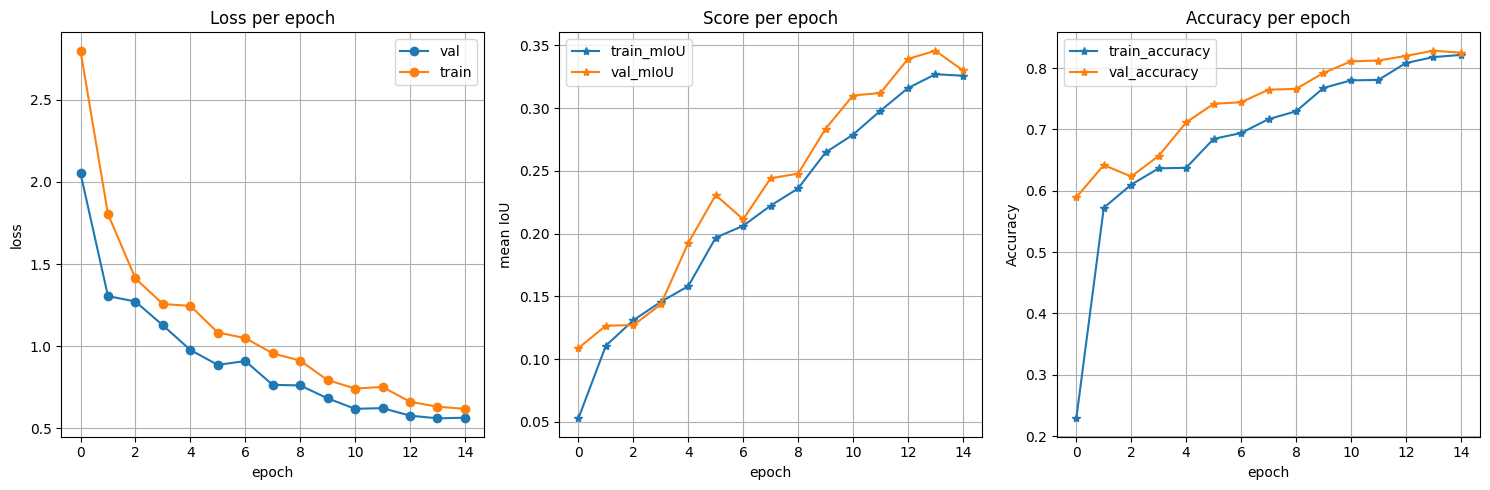

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU', marker='*')
    plt.title('Score per epoch')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()

# Créer une nouvelle figure avec trois sous-graphiques
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.sca(axs[0])
plot_loss(history)
plt.sca(axs[1])
plot_score(history)
plt.sca(axs[2])
plot_acc(history)

plt.tight_layout()
plt.show()


# **Configuration du dataset de test**

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(img_path, mask_path, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

# **Résultats de la tâche de segmentation**

In [ ]:
couleurs_classes = {}

chemin_fichier_csv = "/content/drive/MyDrive/Classroom/MSV/dataset AID/class_dict_seg.csv"

data = pd.read_csv(chemin_fichier_csv)

# Créer un dictionnaire des couleurs des classes à partir des données
couleurs_classes = {}
couleur_normalisee = {}
for index, row in data.iterrows():
    nom_classe = row['name']
    couleur = (row[' r'], row[' g'], row[' b'])
    couleurs_classes[nom_classe] = couleur
    cn = (couleur[0] / 255, couleur[1] / 255, couleur[2] / 255)
    couleur_normalisee[nom_classe] = cn

print("Dictionnaire des couleurs des classes :")
print(couleurs_classes)
cmap = ListedColormap(np.array(list(couleurs_classes.values())) / 255)
print(cmap)

Dictionnaire des couleurs des classes :
{'unlabeled': (0, 0, 0), 'paved-area': (128, 64, 128), 'dirt': (130, 76, 0), 'grass': (0, 102, 0), 'gravel': (112, 103, 87), 'water': (28, 42, 168), 'rocks': (48, 41, 30), 'pool': (0, 50, 89), 'vegetation': (107, 142, 35), 'roof': (70, 70, 70), 'wall': (102, 102, 156), 'window': (254, 228, 12), 'door': (254, 148, 12), 'fence': (190, 153, 153), 'fence-pole': (153, 153, 153), 'person': (255, 22, 96), 'dog': (102, 51, 0), 'car': (9, 143, 150), 'bicycle': (119, 11, 32), 'tree': (51, 51, 0), 'bald-tree': (190, 250, 190), 'ar-marker': (112, 150, 146), 'obstacle': (2, 135, 115), 'conflicting': (255, 0, 0)}


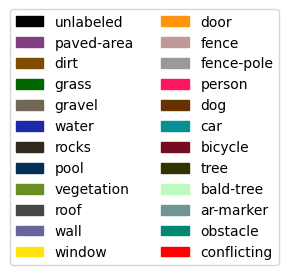

In [ ]:
legend_patches = [Patch(color=couleur, label=nom_classe) for nom_classe, couleur in couleur_normalisee.items()]

plt.figure(figsize=(2, 1))
plt.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.axis('off')  # Turn off the axis
plt.show()

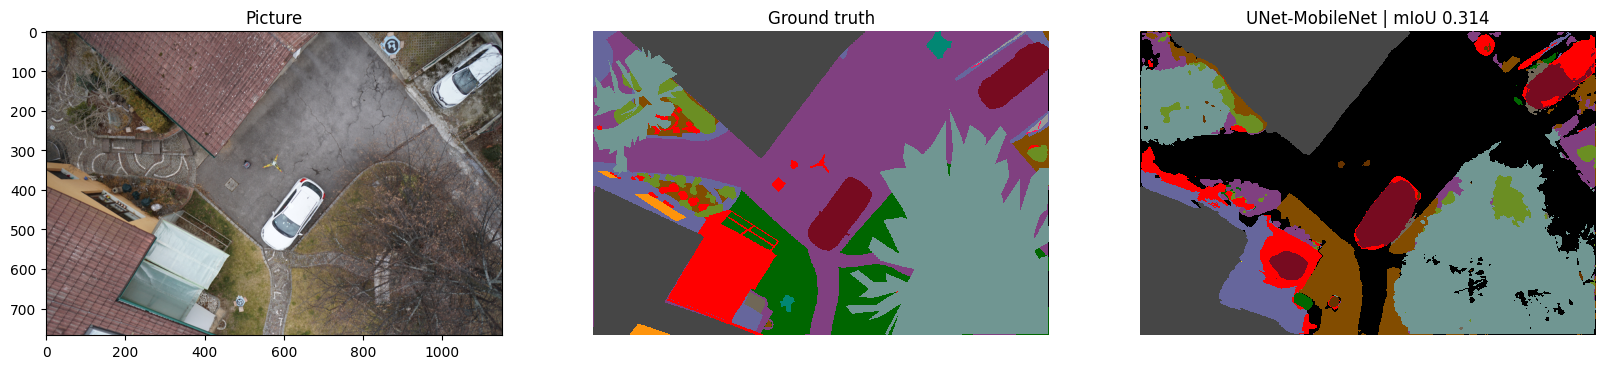

In [ ]:
image, mask = test_set[5]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask, cmap=cmap, interpolation='none')
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask, cmap=cmap, interpolation='none')
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.35895558340428874
Test Set Pixel Accuracy 0.8621709187825519


In [ ]:
def predict_image_mask_per_class(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)

        predictions = torch.argmax(output, dim=1)
        predictions = predictions.cpu().squeeze(0)
    return predictions


In [ ]:
def class_accuracy(true_mask, pred_mask, num_classes):
    class_acc = np.zeros(num_classes)
    for c in range(num_classes):
        true_mask_c = (true_mask == c)
        total_pixels_c = true_mask_c.sum()

        correct_pred_c = np.logical_and(true_mask_c, pred_mask == c).sum()

        if total_pixels_c > 0:
            class_acc[c] = correct_pred_c / total_pixels_c

    return class_acc

class_accuracy_per_class = np.zeros(23)
for img, mask in test_set:
    pred_mask = predict_image_mask_per_class(model, img, mask)
    class_acc = class_accuracy(mask, pred_mask, 23)
    class_accuracy_per_class += class_acc

average_class_accuracy = class_accuracy_per_class / len(test_set)

In [ ]:
colors_df = pd.read_csv('/content/drive/MyDrive/Classroom/MSV/dataset AID/class_dict_seg.csv')
class_names = colors_df['name'].tolist()

headers = ["Class", "Accuracy (%)", "Color"]
table_data = [[colors_df['name'][c], f"{average_class_accuracy[c]*100:.2f}%"] for c in range(23)]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒════════════╤════════════════╕
│ Class      │ Accuracy (%)   │
╞════════════╪════════════════╡
│ unlabeled  │ 0.00%          │
├────────────┼────────────────┤
│ paved-area │ 86.36%         │
├────────────┼────────────────┤
│ dirt       │ 47.13%         │
├────────────┼────────────────┤
│ grass      │ 61.75%         │
├────────────┼────────────────┤
│ gravel     │ 65.36%         │
├────────────┼────────────────┤
│ water      │ 29.13%         │
├────────────┼────────────────┤
│ rocks      │ 0.00%          │
├────────────┼────────────────┤
│ pool       │ 0.47%          │
├────────────┼────────────────┤
│ vegetation │ 54.89%         │
├────────────┼────────────────┤
│ roof       │ 37.49%         │
├────────────┼────────────────┤
│ wall       │ 16.92%         │
├────────────┼────────────────┤
│ window     │ 0.03%          │
├────────────┼────────────────┤
│ door       │ 0.00%          │
├────────────┼────────────────┤
│ fence      │ 0.00%          │
├────────────┼────────────────┤
│ fence-

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

def compute_confusion_matrix(true_masks, pred_masks, num_classes):

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    for true_mask, pred_mask in zip(true_masks, pred_masks):
        # Flatten the masks
        true_mask_flat = true_mask.flatten()
        pred_mask_flat = pred_mask.flatten()

        # Update the confusion matrix
        conf_matrix += confusion_matrix(true_mask_flat, pred_mask_flat, labels=np.arange(num_classes))

    return conf_matrix

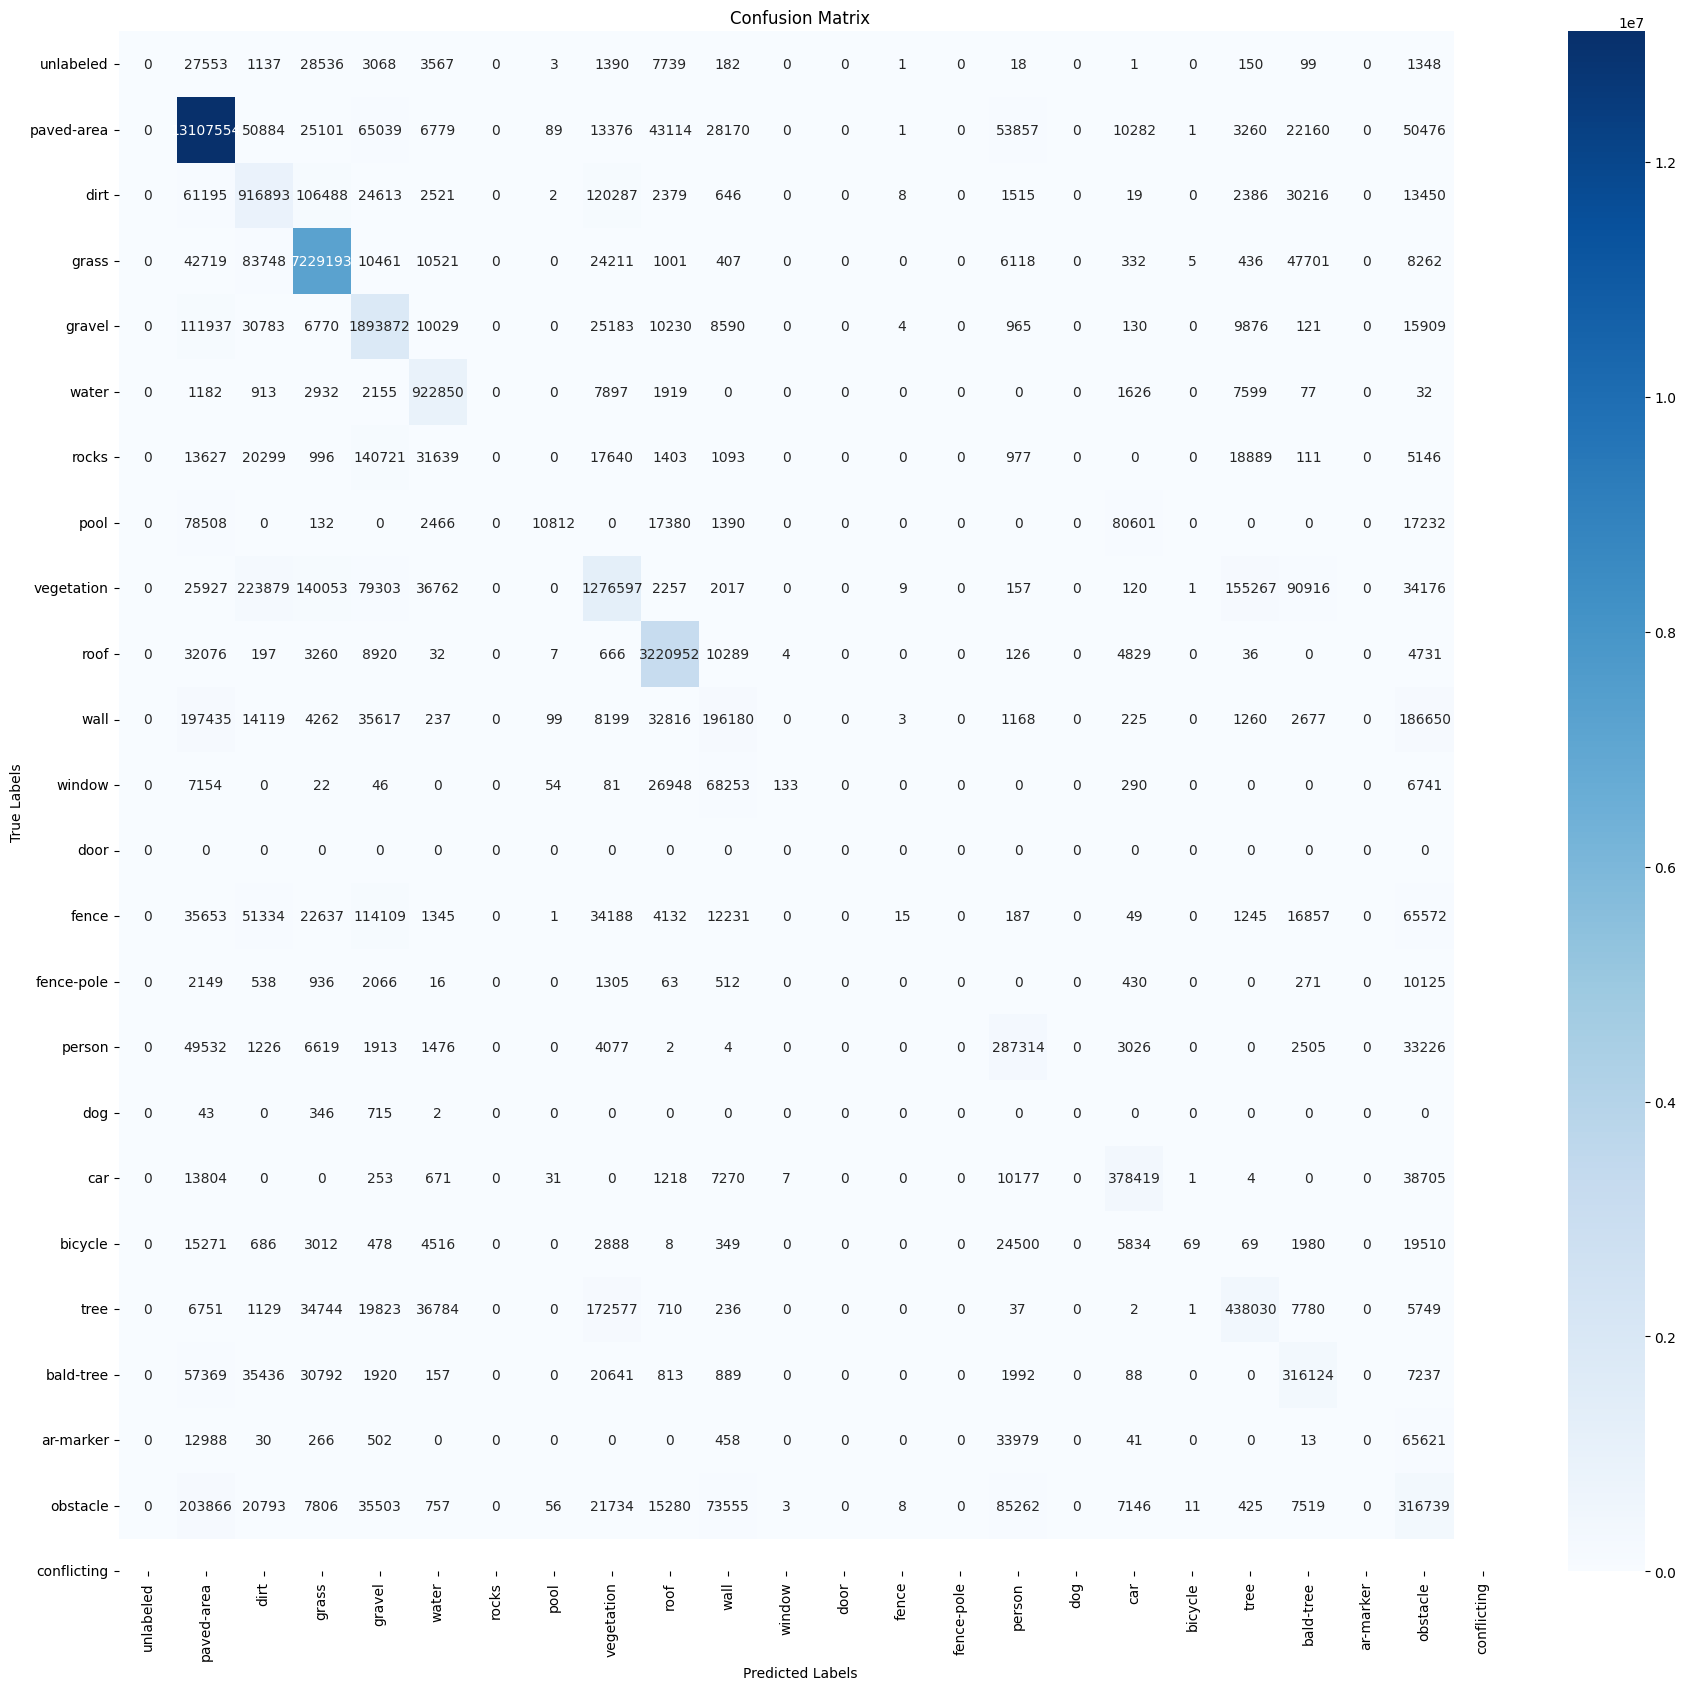

In [ ]:
# Initialize arrays to store predictions and true masks
true_masks = []
pred_masks = []

class_accuracy_per_class = np.zeros(23)
for img, mask in test_set:
    pred_mask = predict_image_mask_per_class(model, img, mask)
    class_acc = class_accuracy(mask, pred_mask, 23)
    class_accuracy_per_class += class_acc

    true_masks.append(mask.cpu().numpy())
    pred_masks.append(pred_mask.cpu().numpy())

average_class_accuracy = class_accuracy_per_class / len(test_set)

colors_df = pd.read_csv('/content/drive/MyDrive/Classroom/MSV/dataset AID/class_dict_seg.csv')
class_names = colors_df['name'].tolist()

# Calculate confusion matrix
conf_matrix = compute_confusion_matrix(true_masks, pred_masks, num_classes=23)

# Plot confusion matrix
plt.figure(figsize=(22, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(class_names)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


In [ ]:
def aggregate_confusion_matrix(conf_matrix, class_groups):
    num_groups = len(class_groups)
    agg_conf_matrix = np.zeros((num_groups, num_groups), dtype=np.int64)
    for i, group_i in enumerate(class_groups):
        for j, group_j in enumerate(class_groups):
            for ci in group_i:
                for cj in group_j:
                    agg_conf_matrix[i, j] += conf_matrix[ci, cj]
    return agg_conf_matrix

╒═════════════════════╤════════════════╕
│ Class               │ Accuracy (%)   │
╞═════════════════════╪════════════════╡
│ Unlabeled           │ 0.00%          │
├─────────────────────┼────────────────┤
│ Artificial Surface  │ 86.36%         │
├─────────────────────┼────────────────┤
│ Natural Surface     │ 47.13%         │
├─────────────────────┼────────────────┤
│ Water               │ 61.75%         │
├─────────────────────┼────────────────┤
│ Vegetation          │ 65.36%         │
├─────────────────────┼────────────────┤
│ Building            │ 29.13%         │
├─────────────────────┼────────────────┤
│ Fences & Poles      │ 0.00%          │
├─────────────────────┼────────────────┤
│ People & Animals    │ 0.47%          │
├─────────────────────┼────────────────┤
│ Vehicles            │ 54.89%         │
├─────────────────────┼────────────────┤
│ Markers & Obstacles │ 37.49%         │
╘═════════════════════╧════════════════╛


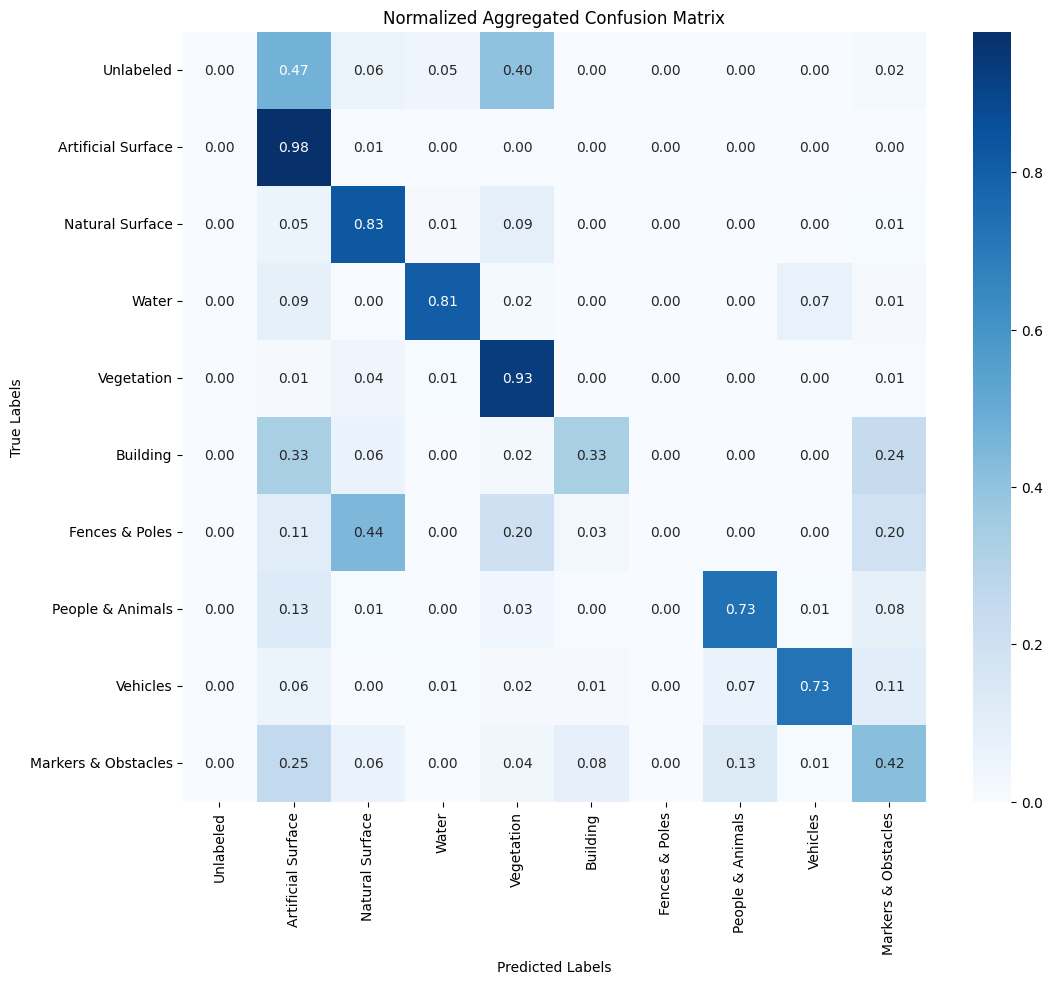

In [ ]:
# Define class groups based on the provided classes
class_groups = [
    [0],  # 'unlabeled'
    [1, 9],  # 'paved-area', 'roof'
    [2, 4, 6],  # 'dirt', 'gravel', 'rocks'
    [5, 7],  # 'water', 'pool'
    [3, 8, 19, 20],  # 'grass', 'vegetation', 'tree', 'bald-tree'
    [10, 11, 12],  # 'wall', 'window', 'door'
    [13, 14],  # 'fence', 'fence-pole'
    [15, 16],  # 'person', 'dog'
    [17, 18],  # 'car', 'bicycle'
    [21, 22]  # 'ar-marker', 'obstacle'
]

group_names = [
    'Unlabeled',
    'Artificial Surface',
    'Natural Surface',
    'Water',
    'Vegetation',
    'Building',
    'Fences & Poles',
    'People & Animals',
    'Vehicles',
    'Markers & Obstacles'
]

# Calculate confusion matrix
conf_matrix = compute_confusion_matrix(true_masks, pred_masks, num_classes=23)

# Aggregate confusion matrix based on defined class groups
agg_conf_matrix = aggregate_confusion_matrix(conf_matrix, class_groups)

# Normalize the aggregated confusion matrix
agg_conf_matrix_normalized = agg_conf_matrix.astype('float') / agg_conf_matrix.sum(axis=1)[:, np.newaxis]

# Print class accuracies
headers = ["Class", "Accuracy (%)"]
table_data = [[group_names[c], f"{average_class_accuracy[c]*100:.2f}%"] for c in range(len(group_names))]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# Plot normalized aggregated confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(agg_conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=group_names, yticklabels=group_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Aggregated Confusion Matrix')
plt.show()
